## Addestramento AlexNet

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score
import copy
import time
import csv
import matplotlib.pyplot as plt


# Funzione di filtro per i file validi
def is_valid_file(file_path):
    valid_extensions = ['.png', '.jpg', '.jpeg']
    return any(file_path.lower().endswith(ext) for ext in valid_extensions) and '.ipynb_checkpoints' not in file_path


# Funzione per caricare il dataset
def load_dataset(phase):
    return datasets.ImageFolder(os.path.join(dataset_dir, phase), transform=data_transforms[phase],
                                is_valid_file=is_valid_file)


# Funzione di addestramento
def train_model(model, criterion, optimizer, scheduler, num_epochs=50, patience=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    start_time = time.time()

    train_losses, val_losses = [], []
    train_f1s, val_f1s = [], []
    train_precisions, val_precisions = [], []
    train_recalls, val_recalls = [], []

    epochs_no_improve = 0

    # Prepara il file CSV per salvare le metriche
    with open(metrics_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Phase', 'Loss', 'Accuracy', 'F1', 'Precision', 'Recall'])

        for epoch in range(num_epochs):
            epoch_start_time = time.time()
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0
                all_labels = []
                all_preds = []

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    all_labels.extend(labels.cpu().numpy())
                    all_preds.extend(preds.cpu().numpy())

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)
                epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
                epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)

                if phase == 'train':
                    scheduler.step()
                    train_losses.append(epoch_loss)
                    train_f1s.append(epoch_f1)
                    train_precisions.append(epoch_precision)
                    train_recalls.append(epoch_recall)
                else:
                    val_losses.append(epoch_loss)
                    val_f1s.append(epoch_f1)
                    val_precisions.append(epoch_precision)
                    val_recalls.append(epoch_recall)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f}')

                # Salva le metriche nel file CSV
                writer.writerow([epoch, phase, epoch_loss, epoch_acc.item(), epoch_f1, epoch_precision, epoch_recall])

                if phase == 'val' and epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                elif phase == 'val':
                    epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print("Early stopping")
                break

            # Salva i pesi del modello ad ogni epoca
            epoch_weights_path = os.path.join(weights_dir, f'epoch_{epoch+1}_model.pth')
            torch.save(model.state_dict(), epoch_weights_path)
            print(f"Modello salvato in {epoch_weights_path}")

            epoch_time = time.time() - epoch_start_time
            elapsed_time = time.time() - start_time
            remaining_time = (num_epochs - (epoch + 1)) * (elapsed_time / (epoch + 1))
            print(f'Tempo impiegato per epoch {epoch}: {epoch_time // 60:.0f}m {epoch_time % 60:.0f}s')
            print(f'Tempo rimanente stimato: {remaining_time // 60:.0f}m {remaining_time % 60:.0f}s')
            print()

    total_time = time.time() - start_time
    print(f'Tempo totale di addestramento: {total_time // 60:.0f}m {total_time % 60:.0f}s')
    print(f'Best val F1: {best_f1:4f}')
    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_f1s, val_f1s, train_precisions, val_precisions, train_recalls, val_recalls


# Funzione di test
def test_model(model, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []

    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    test_loss = running_loss / dataset_sizes['test']
    test_acc = running_corrects.double() / dataset_sizes['test']
    test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)
    test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f} F1: {test_f1:.4f} Precision: {test_precision:.4f} Recall: {test_recall:.4f}')

def verify_structure(dataset_dir, phase):
    phase_dir = os.path.join(dataset_dir, phase)
    if not os.path.exists(phase_dir):
        print(f"Directory not found: {phase_dir}")
    else:
        print(f"Directory exists: {phase_dir}")
        for root, dirs, files in os.walk(phase_dir):
            print(f"Checking directory: {root}")
            print(f"Contains {len(files)} files")

if __name__ == '__main__':

    # Configurazione dei percorsi
    dataset_dir = 'Alfabeto1_Multiclasse'  # Modifica questo percorso
    weights_dir = 'AlexNet_saved_models_MultiClass'  # Modifica questo percorso
    metrics_path = os.path.join(weights_dir, 'training_metrics.csv')
    weights_path = os.path.join(weights_dir, 'AlexNet_finetuned.pth')

    # Crea la directory se non esiste
    os.makedirs(weights_dir, exist_ok=True)

    # Trasformazioni
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_classes = len(os.listdir(os.path.join(dataset_dir, 'train')))


    weights = models.AlexNet_Weights.IMAGENET1K_V1
    model = models.alexnet(weights=weights)



    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, num_classes)

    # Determina il numero di classi nel dataset
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Verifica la struttura per 'train', 'val' e 'test'
    for phase in ['train', 'val', 'test']:
        verify_structure(dataset_dir, phase)

    # Caricamento del dataset di addestramento
    train_dataset = load_dataset('train')
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

    # Aggiorna i dizionari
    image_datasets = {'train': train_dataset}
    dataloaders = {'train': train_loader}
    dataset_sizes = {'train': len(train_dataset)}
    class_names = train_dataset.classes

    print(f'Numero di elementi nel dataset di addestramento: {len(train_dataset)}')

    # Caricamento del dataset di validazione
    val_dataset = load_dataset('val')
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

    # Aggiorna i dizionari
    image_datasets['val'] = val_dataset
    dataloaders['val'] = val_loader
    dataset_sizes['val'] = len(val_dataset)

    if os.path.exists(weights_path):
        print(f"Caricamento dei pesi salvati da {weights_path}")
        model.load_state_dict(torch.load(weights_path))
    else:
        print("Nessun peso salvato trovato. Addestramento da zero.")

    model, train_losses, val_losses, train_f1s, val_f1s, train_precisions, val_precisions, train_recalls, val_recalls = train_model(
        model, criterion, optimizer, scheduler, num_epochs=50)

    # Salvataggio del modello finale
    torch.save(model.state_dict(), weights_path)
    print(f"Modello salvato in {weights_path}")

## Analisi delle epoche 

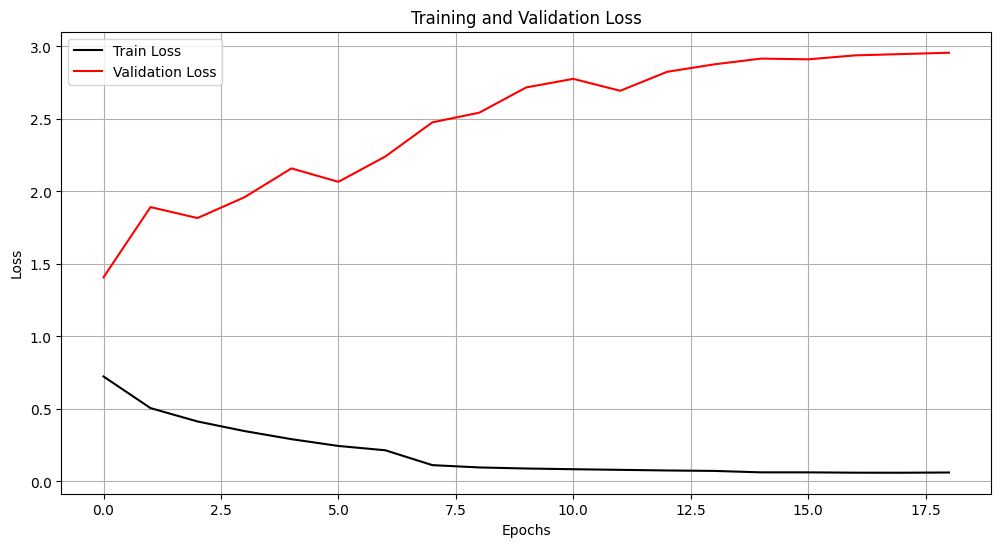

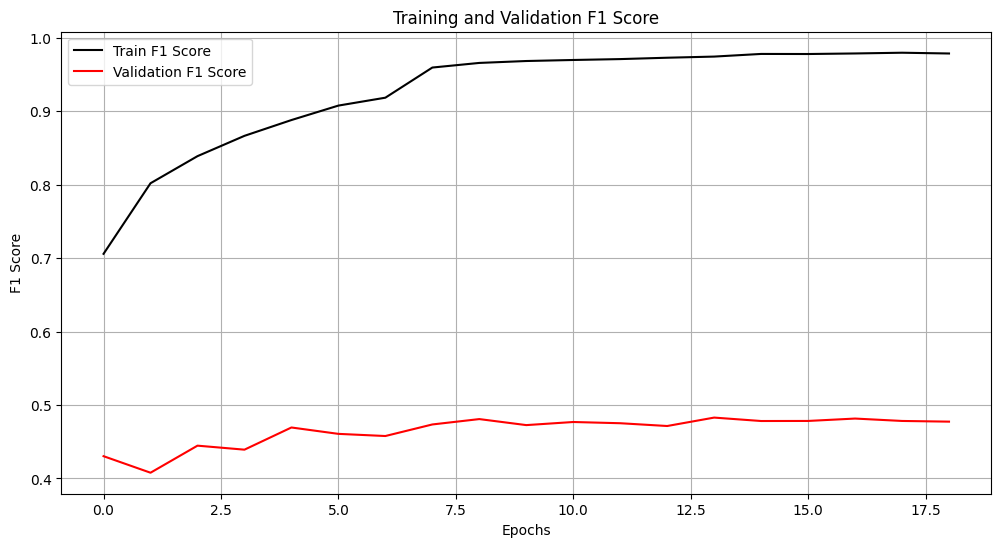

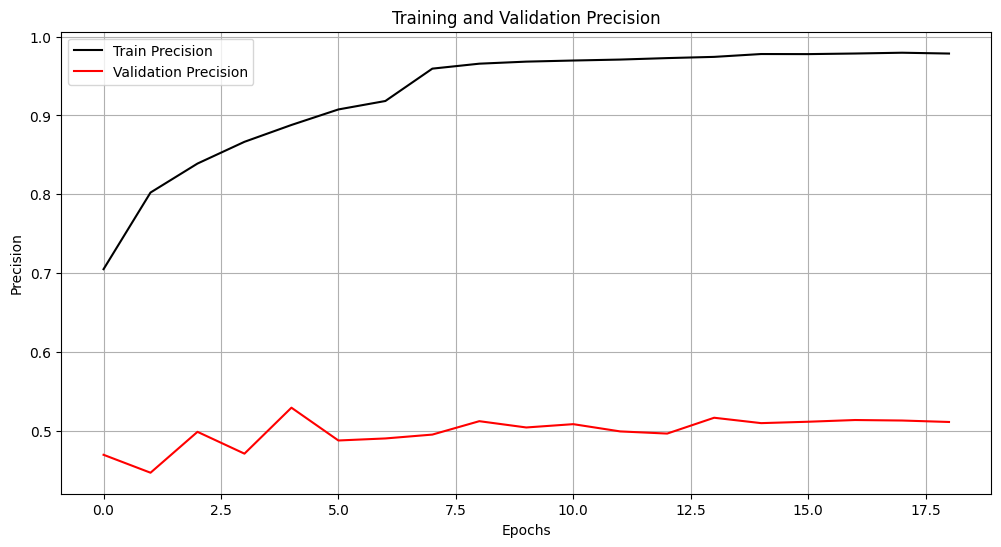

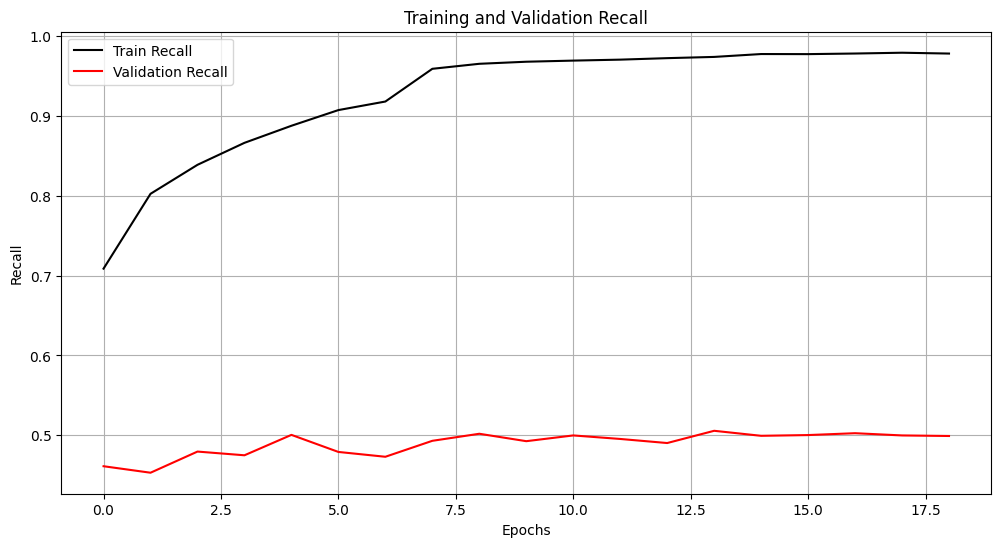

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Leggere il file CSV
file_path = 'AlexNet_saved_models_MultiClass/training_metrics.csv'
df = pd.read_csv(file_path)

# Filtrare i dati per fase di training e validazione
train_data = df[df['Phase'] == 'train']
val_data = df[df['Phase'] == 'val']

# Creare il grafico per train_loss e val_loss
plt.figure(figsize=(12, 6))
plt.plot(train_data['Epoch'], train_data['Loss'], color='black', label='Train Loss')
plt.plot(val_data['Epoch'], val_data['Loss'], color='red', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Creare il grafico per f1_score di training e validation
plt.figure(figsize=(12, 6))
plt.plot(train_data['Epoch'], train_data['F1'], color='black', label='Train F1 Score')
plt.plot(val_data['Epoch'], val_data['F1'], color='red', label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Creare il grafico per precision di training e validation
plt.figure(figsize=(12, 6))
plt.plot(train_data['Epoch'], train_data['Precision'], color='black', label='Train Precision')
plt.plot(val_data['Epoch'], val_data['Precision'], color='red', label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')
plt.legend()
plt.grid(True)
plt.show()

# Creare il grafico per recall di training e validation
plt.figure(figsize=(12, 6))

plt.plot(train_data['Epoch'], train_data['Recall'], color='black', label='Train Recall')
plt.plot(val_data['Epoch'], val_data['Recall'], color='red', label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.legend()
plt.grid(True)
plt.show()

## Testing AlexNet

Directory exists: DatasetMulticlass
Directory exists: DatasetMulticlass\test
Number of classes: 5
Caricamento dei pesi salvati da C:\Users\ddefs\Documents\University\FVAB - Nappi\Project\AlexNet_saved_models_MultiClass\AlexNet_finetuned.pth
Test Loss: 1.6182 Acc: 0.2280 F1: 0.2494 Precision: 0.3454 Recall: 0.2280


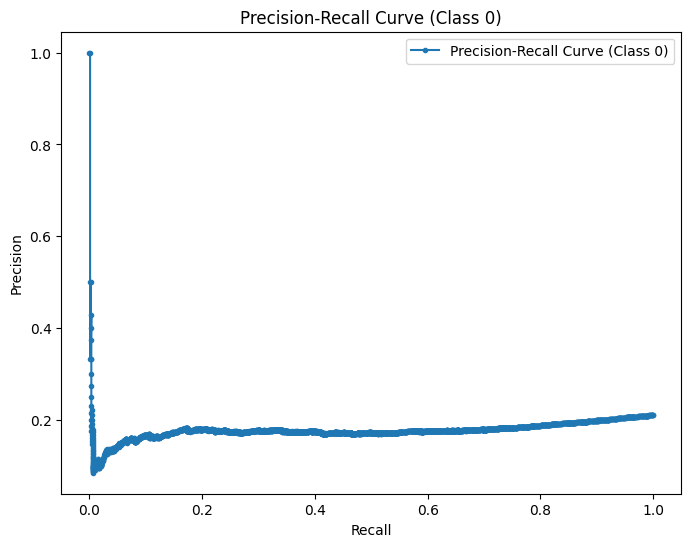

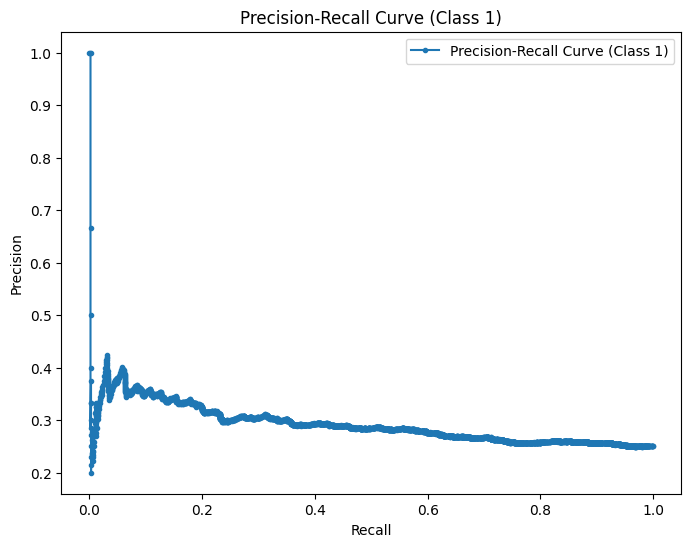

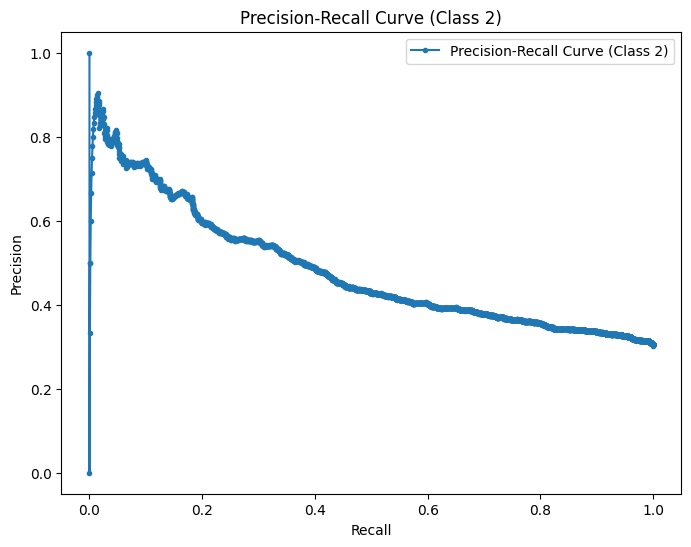

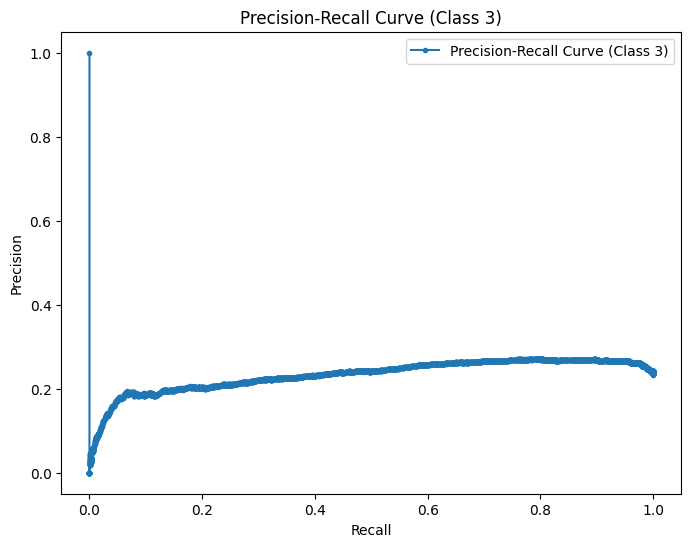

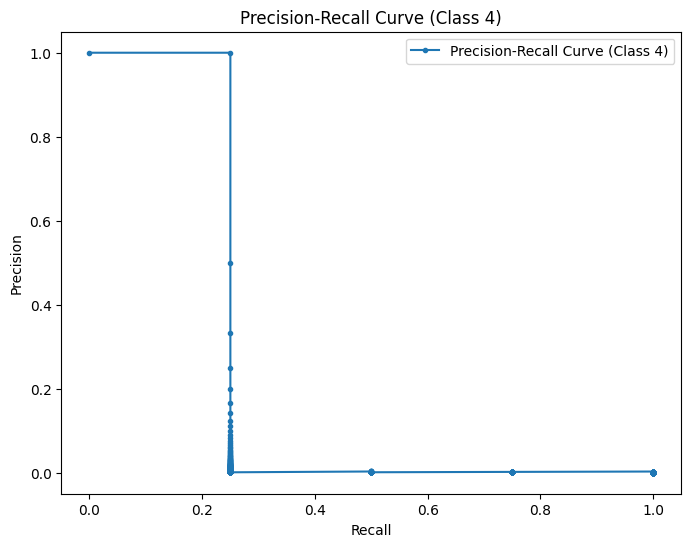

In [2]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from PIL import UnidentifiedImageError
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
import csv
import matplotlib.pyplot as plt
import numpy as np

# Configurazione dei percorsi
dataset_dir = 'DatasetMulticlass'  
weights_path = 'AlexNet_saved_models_MultiClass/AlexNet_finetuned.pth'
metrics_path = 'AlexNet_saved_models_MultiClass/training_metrics.csv'
results_path = 'testing/AlexNet_Multiclass.csv'

# Verifica se il percorso del dataset è corretto
if not os.path.exists(dataset_dir):
    raise FileNotFoundError(f"Directory not found: {dataset_dir}")
else:
    print(f"Directory exists: {dataset_dir}")

# Trasformazioni
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Funzione di filtro per i file validi
def is_valid_file(file_path):
    valid_extensions = ['.png', '.jpg', '.jpeg']
    return any(file_path.lower().endswith(ext) for ext in valid_extensions) and '.ipynb_checkpoints' not in file_path

# Funzione per caricare il dataset
def load_dataset(phase):
    dataset_path = os.path.join(dataset_dir, phase)
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Directory not found: {dataset_path}")
    return datasets.ImageFolder(dataset_path, transform=data_transforms[phase], is_valid_file=is_valid_file)

# Funzione di test
def test_model(model, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []
    all_probs = []

    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)  # Probabilità per ogni classe
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    test_loss = running_loss / dataset_sizes['test']
    test_acc = running_corrects.double() / dataset_sizes['test']
    test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)
    test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f} F1: {test_f1:.4f} Precision: {test_precision:.4f} Recall: {test_recall:.4f}')

    return test_loss, test_acc, test_f1, test_precision, test_recall, all_labels, all_probs

# Funzione per salvare i risultati del test
def save_test_results(global_metrics, per_class_metrics, results_path):
    with open(results_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Test Loss', 'Test Accuracy', 'Test F1', 'Test Precision', 'Test Recall'])
        writer.writerow(global_metrics)
        writer.writerow(['Class', 'Best Threshold', 'Precision', 'Recall', 'F1'])
        writer.writerows(per_class_metrics)

# Caricamento del modello e impostazioni
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.alexnet()
num_ftrs = model.classifier[6].in_features

# Determina il numero di classi nel dataset di test
test_dir = os.path.join(dataset_dir, 'test')
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Directory not found: {test_dir}")
else:
    print(f"Directory exists: {test_dir}")

class_folders = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
num_classes = len(class_folders)
print(f"Number of classes: {num_classes}")

# Modifica il livello finale del modello
model.classifier[6] = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Carica i pesi del modello tranne l'ultimo livello
absolute_weights_path = os.path.abspath(weights_path)
if os.path.exists(absolute_weights_path):
    print(f"Caricamento dei pesi salvati da {absolute_weights_path}")
    state_dict = torch.load(absolute_weights_path, map_location=torch.device('cpu'))
    state_dict['classifier.6.weight'] = model.classifier[6].weight
    state_dict['classifier.6.bias'] = model.classifier[6].bias
    model.load_state_dict(state_dict, strict=False)
else:
    print(f"Nessun peso salvato trovato. Assicurati di avere il file dei pesi salvato in {absolute_weights_path}")

criterion = nn.CrossEntropyLoss()

# Caricamento del dataset di test con gestione delle eccezioni
def load_dataset_with_error_handling(phase):
    dataset_path = os.path.join(dataset_dir, phase)
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Directory not found: {dataset_path}")

    dataset = datasets.ImageFolder(dataset_path, transform=data_transforms[phase], is_valid_file=is_valid_file)

    valid_samples = []
    for path, target in dataset.samples:
        try:
            dataset.loader(path)  # Try to load the image to ensure it's valid
            valid_samples.append((path, target))
        except UnidentifiedImageError:
            print(f"UnidentifiedImageError: {path}")

    dataset.samples = valid_samples
    return dataset

test_dataset = load_dataset_with_error_handling('test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

# Aggiorna i dizionari
image_datasets = {'test': test_dataset}
dataloaders = {'test': test_loader}
dataset_sizes = {'test': len(test_dataset)}

# Esegui il test del modello
test_loss, test_acc, test_f1, test_precision, test_recall, all_labels, all_probs = test_model(model, criterion)

# Converti all_probs in un array NumPy
all_probs = np.array(all_probs)

# Salva le metriche globali
global_metrics = [test_loss, test_acc.item(), test_f1, test_precision, test_recall]

# Calcola la curva Precision-Recall e la soglia ottimale per ogni classe
thresholds_and_metrics = []
for i in range(num_classes):
    precisions, recalls, thresholds = precision_recall_curve([1 if label == i else 0 for label in all_labels], all_probs[:, i])
    
    # Calcola F1 scores evitando divisione per zero
    f1_scores = np.divide(2 * (precisions * recalls), (precisions + recalls), out=np.zeros_like(precisions), where=(precisions + recalls) != 0)
    
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index] if best_index < len(thresholds) else 1.0
    best_precision = precisions[best_index]
    best_recall = recalls[best_index]
    best_f1 = f1_scores[best_index]
    
    thresholds_and_metrics.append([i, best_threshold, best_precision, best_recall, best_f1])
    
    # Visualizzazione della curva Precision-Recall per ogni classe
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, marker='.', label=f'Precision-Recall Curve (Class {i})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (Class {i})')
    plt.legend()
    plt.show()

# Salva i risultati del test inclusa la soglia e le metriche relative per ogni classe
save_test_results(global_metrics, thresholds_and_metrics, results_path)
